In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2
import calendar
import random
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
conn = psycopg2.connect(
host = "shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com",
  user = "toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c",
  password = "toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_password",
  database = "toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_db",
  port = '5432'
)

In [3]:
# query1 = """select o.id as order_id,
#             o.created_at::date as order_date,
#             o.customer_id as user_id,
#             oli.product_id as product_id,
#             oli.name as product_name,
#             CASE
#         WHEN cancelled_at IS NOT NULL THEN 'Cancelled'
#          ELSE 'Delivered'
#      END as order_status,
#             oli.quantity as quantity,
#             oli.price as sp
#             from orders o
#             join order_line_item oli on oli.order_id = o.id"""

query1='''
    select o.id as order_id,
    o.created_at::date as order_date,
    o.customer_id as user_id,
    o.total_line_items_price as MRP,
    o.total_discounts as discount_amount,
    o.total_price as total_price

    from orders o
    WHERE
    cancelled_at is NULL;
'''

query2='''
    select oli.order_id as order_id,
    oli.product_id as product_id,
    oli.name as product_name,
    oli.quantity as quantity,
    oli.price as sp
    from order_line_item oli;
'''

o=pd.read_sql(query1,conn)
r=pd.read_sql(query2,conn)
data=pd.merge(o,r,on='order_id',how='left')

In [4]:
data = data.dropna()

In [5]:
data["order_date"] = pd.to_datetime(data["order_date"])

In [6]:
data['WeekCount']=data['order_date'].dt.strftime('%y-w%U')

In [7]:
data=data.sort_values('order_date')
WeekList=data['WeekCount'].unique()

In [8]:
WeekList.tolist()
output_list = []

for i in range(len(WeekList) - 1):
    output_list.append(WeekList[i])
    current_week = int(WeekList[i].split('-w')[1])
    next_week = int(WeekList[i + 1].split('-w')[1])
    missing_weeks = next_week - current_week - 1
    for j in range(1, missing_weeks + 1):
        missing_week = current_week + j
        output_list.append(f'{WeekList[i][:3]}w{missing_week:02d}')

output_list.append(WeekList[-1])

In [9]:
# output_list=output_list[-52:]
# output_list

In [10]:
#New/Repeat Tag
orderuserlevel=data.groupby(['order_id','user_id']).agg(
          order_date=pd.NamedAgg(column='order_date', aggfunc='min'),

    ).reset_index()
orderuserlevel=orderuserlevel.sort_values('order_date')
orderuserlevel['TrxnRank'] = orderuserlevel.groupby('user_id')['order_date'].rank(method='first')
orderuserlevel



# data = data[data['order_date'] >= '2023-01-01']
# data=data[data['order_date'] <= '2023/12/31']

data=pd.merge(data,
         orderuserlevel[['order_id','TrxnRank']],
         on="order_id",
         how ='left')
data['New']=0
data['Repeat']=0
data.loc[data['TrxnRank']==1,'New']=1
data.loc[data['TrxnRank']>1,'Repeat']=1


#AOV Contribution
data['ordervalue']=data['quantity']*data['sp']
data['AOVContribution']=data['ordervalue']/data["order_id"].nunique()
data['discount_ratio'] = data['discount_amount']/data['mrp']
data['new_ordervalue']= data['ordervalue']-(data['ordervalue']*data['discount_ratio'])

In [11]:
productsegstats_weekly = {}
for x in output_list:
    x3 = data[data["WeekCount"] <= x]
    try:
        totalcarts=x3['order_id'].nunique()
        product_level=x3.groupby(['product_id', 'product_name']).agg(
                Carts=pd.NamedAgg(column='order_id', aggfunc='nunique'),
                Quantity=pd.NamedAgg(column='quantity', aggfunc='sum'),
                ASP=pd.NamedAgg(column='sp', aggfunc='mean'),
                NewOrders=pd.NamedAgg(column='New', aggfunc='sum'),
                RepeatOrders=pd.NamedAgg(column='Repeat', aggfunc='sum'),
                Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
                AOVContribution=pd.NamedAgg(column='AOVContribution', aggfunc='sum'),
                Total_Order_Value=pd.NamedAgg(column='new_ordervalue', aggfunc='sum'),
                Order_Count=pd.NamedAgg(column='order_id', aggfunc='nunique')
        ).reset_index()
        data_new=x3[x3['TrxnRank']==1]
        xuser_count = data_new.groupby(["product_name"]).agg(
        x_trxn_pool = pd.NamedAgg(column = "user_id", aggfunc = 'nunique'),
        x_user_list = pd.NamedAgg(column = "user_id", aggfunc = lambda x: [x.unique()])
        ).reset_index()
        data_repeat=x3[x3['TrxnRank']==2]
        repeat_users=data_repeat['user_id'].to_list()
        l=[]
        for i in range (len(xuser_count)):
            a=(xuser_count.iloc[i,2])[0]
            b=[x for x in a if x in repeat_users]
            l.append(len(b))

        xuser_count['repeat_pool']=l

        yuser_count = data_repeat.groupby('product_name').agg(
        y_trxn_pool = pd.NamedAgg(column = "user_id", aggfunc = 'nunique')
        ).reset_index()
        main_grouped_for_title = pd.merge(xuser_count, yuser_count, on='product_name', how='left')
        main_grouped_for_title['y_trxn_pool'].fillna(0, inplace=True)
        result = main_grouped_for_title.copy()

        result['Conversion_Rate_x_to_y'] = result['repeat_pool']/result['x_trxn_pool']
        result['Conversion_Rate_x_to_y'].fillna(0, inplace= True)
        conversion_result = result
        productlevel=pd.merge(product_level,conversion_result,on='product_name', how='left')


        productlevel['NewRepeatConversionRatio']=productlevel['Conversion_Rate_x_to_y']
        productlevel['NewRepeatConversionRatio'].fillna(0)
        productlevel=productlevel.sort_values('NewRepeatConversionRatio')
        productlevel['CartPenetration']=productlevel['Carts']/totalcarts
        productlevel['QpC']=productlevel['Quantity']/productlevel['Carts']
        productlevel['ASPXQpC']=productlevel['ASP']*productlevel['QpC']

        CP_labels, NewRatio_labels,ASP_labels, QpC_labels =  range(1,5), range(1,5),range(1,5),range(1,5)
        productlevel['CP_score'] = productlevel['CartPenetration'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = CP_labels)).astype('int64')
        productlevel['NewRepeatConversion_score'] = productlevel['NewRepeatConversionRatio'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = NewRatio_labels))#.astype('int64')
        productlevel['ASP_score'] = productlevel['ASP'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = ASP_labels)).astype('int64')
        # productlevel['QpC_score'] = productlevel['QpC'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = QpC_labels)).astype('int64')
        # productlevel['SumScore'] = productlevel['CP_score'] + productlevel['NewRepeatConversion_score'] + productlevel['ASP_score'] + productlevel['QpC_score']
        def ProductCohortLables2(df):
            if ((df['CP_score']>2) and (df['NewRepeatConversion_score']>2)):
                return 'Hero Products'
            elif df['NewRepeatConversion_score'] >2:
                return 'High Repeat Products'
            elif (df['CP_score'] >2):
                return 'New Business Products'
            elif (df['ASP_score'] >3):
                return 'High Value & Slow Moving Products'
            elif (df['ASP_score'] <=3):
                return 'Low Value & Slow Moving Products'
            else:
                return 'Low Value & Slow Moving Products'
        productlevel['Product Cohort Lables'] = productlevel.apply(ProductCohortLables2, axis=1)
        p1=productlevel.groupby(
          'Product Cohort Lables'
        ).agg(
          ProductCount=pd.NamedAgg(column='product_name', aggfunc='nunique'),
          Orders=pd.NamedAgg(column='Carts', aggfunc='sum'),
          Total_Quantity=pd.NamedAgg(column='Quantity', aggfunc='sum'),
          Users=pd.NamedAgg(column='Users', aggfunc='sum'),
          AverageSellingPrice=pd.NamedAgg(column='ASP', aggfunc='mean'),
          QuantityperCart=pd.NamedAgg(column='QpC', aggfunc='mean'),
          CartPenetration  =pd.NamedAgg(column='CartPenetration', aggfunc='sum'),
          NewRepeatConversionRatio=pd.NamedAgg(column='NewRepeatConversionRatio', aggfunc='mean'),
          Total_Order_Value=pd.NamedAgg(column='Total_Order_Value', aggfunc='sum'),
          # OrderCount=pd.NamedAgg(column='Total_Order_Value', aggfunc='sum'),
          #  NewUserRatio=pd.NamedAgg(column='NewUserRatio', aggfunc='mean'),
          NewOrders=pd.NamedAgg(column='NewOrders', aggfunc='sum'),
          ASPXQpC=pd.NamedAgg(column='ASPXQpC', aggfunc='sum'),
          # AOVContribution=pd.NamedAgg(column='AOVContribution', aggfunc='sum'),
          Order_Count=pd.NamedAgg(column='Order_Count', aggfunc='sum'),
          Top10SKUs=pd.NamedAgg(column='product_name', aggfunc=lambda x: x.value_counts().index[:10]),
          Bottom10SKUs=pd.NamedAgg(column='product_name', aggfunc=lambda x: x.value_counts().index[-10:-1])

        ).reset_index()
        p1=p1.sort_values('CartPenetration', ascending =False)
        p1['AOVContribution']=p1['Total_Order_Value']/p1['Order_Count'].sum()
        p1
        p1['ProductCountMix']=p1['ProductCount']/p1['ProductCount'].sum()
        p1['OrdersMix']=p1['Orders']/p1['Orders'].sum()
        p1['UsersMix']=p1['Users']/p1['Users'].sum()
        p1['AOVContribution(%)']=p1['AOVContribution']/p1['AOVContribution'].sum()
        p1['OrderPerSKU']=p1['Orders']/p1['ProductCount']
        p1.set_index("Product Cohort Lables", inplace= True)
        product_cohort_labels = ['Hero Products', 'High Repeat Products', 'New Business Products', 'High Value & Slow Moving Products', 'Low Value & Slow Moving Products']
        cols = p1.columns.tolist()
        dummy_df = pd.DataFrame(index=product_cohort_labels, columns=cols)

        for i in product_cohort_labels:
            try:
                dummy_df.loc[i] = p1.loc[i]
            except KeyError:
                pass

        dummy_df = dummy_df.fillna(0)
        productsegstats_weekly[x] = dummy_df
    except:
        pass

In [15]:
p1

,ProductCount,Orders,Total_Quantity,Users,AverageSellingPrice,QuantityperCart,CartPenetration,NewRepeatConversionRatio,Total_Order_Value,NewOrders,ASPXQpC,Order_Count,Top10SKUs,Bottom10SKUs,AOVContribution,ProductCountMix,OrdersMix,UsersMix,AOVContribution(%),OrderPerSKU
Product Cohort Lables,,,,,,,,,,,,,,,,,,,,
New Business Products,196,49915,54143,45547,1169.354165,1.103769,0.789494,0.152509,2.306280e+07,38836,255518.274675,49915,"[Honey & Caramel Blend - 500 gm / Cold Brew, T...",[Holiday Blend Coffee - Turkish Coffee / 250 g...,275.775127,0.214442,0.596862,0.607577,0.555917,254.668367
Hero Products,261,32524,35980,28275,1000.612046,1.101956,0.514425,0.398249,1.688440e+07,17022,290254.521003,32524,[Papáia: Papaya Fermened Coffee - Whole Beans ...,[Brazil Cerrado Coffee (Latin America) - Cold ...,201.896472,0.285558,0.388908,0.377176,0.406990,124.613027
Low Value & Slow Moving Products,186,470,504,461,904.109089,1.058436,0.007434,0.021250,3.079764e+05,291,177758.279048,470,[Brazil & Colombia Speciality Instant Coffee (...,[Papáia: Papaya Fermened Coffee - Chemex / 250...,3.682651,0.203501,0.005620,0.006150,0.007424,2.526882
High Repeat Products,145,457,488,432,1552.647898,1.061117,0.007228,0.708982,5.982487e+05,319,236145.760533,457,"[Hario Mizudashii Cold Brew Pot - Red, Barrel ...",[Thippanahalli Estate Coffee - Turkish Coffee ...,7.153603,0.158643,0.005465,0.005763,0.014420,3.151724
High Value & Slow Moving Products,126,263,289,250,2588.946334,1.075265,0.004160,0.012025,6.326096e+05,139,347253.823413,263,[Single Malt Whiskey Barrel Aged Coffee - Turk...,"[Aeropress Go Coffee Maker, Mullayangiri Estat...",7.564477,0.137856,0.003145,0.003335,0.015249,2.087302


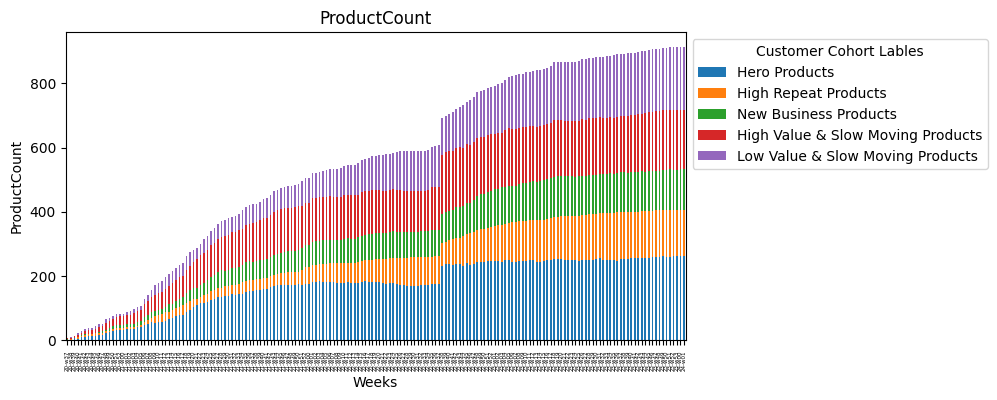

In [12]:
each_metric_df = {}
ListofCustomerCohortVariables = p1.columns.to_list()
Line_Chart_Variable_List_Product = ['AverageSellingPrice', 'QuantityperCart', 'CartPenetration', 'NewUserRatio', 'ASPXQpC']
Stack_Chart_Variable_List_Product = ['ProductCount', 'Orders', 'AOVContribution', 'Quantity', 'NewOrders', 'NewRepeatConversionRatio', 'Users']
for week, df in productsegstats_weekly.items():
    df.sort_index(inplace=True)

def metric_graph(metric):
  if metric in Line_Chart_Variable_List_Product:
    column_df = pd.DataFrame({week: df[metric].tolist() for week, df in productsegstats_weekly.items()})
    column_df.index = product_cohort_labels
    column_transposed = column_df.transpose()
    insights_table = column_transposed
    each_metric_df[metric] = column_transposed
    weeks = column_transposed.index.to_list()
    for column_name, values in column_transposed.items():
      plt.plot(weeks, values, label=column_name)
    plt.xlabel('Weeks')
    plt.ylabel(metric)
    plt.title(f'{metric}')
    plt.xticks(fontsize=4, rotation=90)
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), title = 'Customer Cohort Lables')
    plt.show()

  if metric in Stack_Chart_Variable_List_Product:
    variable_df = pd.DataFrame({week: df[metric].tolist() for week, df in productsegstats_weekly.items()})
    variable_df.index = product_cohort_labels
    variable_df_transposed = variable_df.transpose()
    each_metric_df[metric] = variable_df_transposed
    insights_table = variable_df_transposed
    graph2 = variable_df_transposed
    graph2.plot(kind='bar', stacked=True, figsize=(8, 4))
    plt.title(f'{metric}')
    plt.xticks(fontsize=4)
    plt.xlabel('Weeks')
    plt.ylabel(metric)
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), title = 'Customer Cohort Lables')
    plt.show()
  return insights_table

output = metric_graph('ProductCount')

In [13]:
output

,Hero Products,High Repeat Products,New Business Products,High Value & Slow Moving Products,Low Value & Slow Moving Products
20-w37,2,0,1,3,1
20-w38,2,1,1,3,2
20-w39,6,0,0,6,0
20-w40,4,6,1,4,6
20-w41,9,5,2,7,5
...,...,...,...,...,...
23-w51,260,146,126,185,196
23-w52,261,145,125,187,196
23-w53,261,145,125,187,196
24-w00,261,145,126,186,196


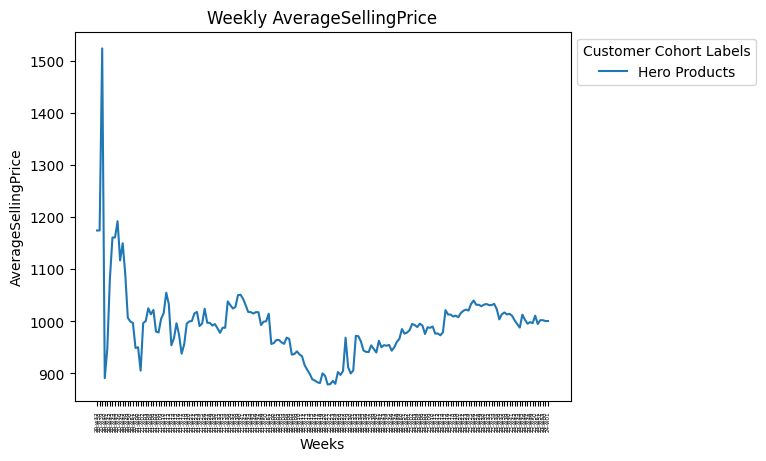

In [14]:
def metric_cohort_graph(metric, cohort):
    if metric in Line_Chart_Variable_List_Product:
        column_df = pd.DataFrame({week: df[metric].tolist() for week, df in productsegstats_weekly.items()})
        column_df.index = product_cohort_labels
        column_transposed = column_df.transpose()
        each_metric_df[metric] = column_transposed[cohort]  # Select only the specified cohort column

        # Replace zero values with np.nan
        each_metric_df[metric] = np.where(each_metric_df[metric] == 0, np.nan, each_metric_df[metric])

        plt.plot(column_transposed.index, each_metric_df[metric], label=cohort)
        plt.xlabel('Weeks')
        plt.ylabel(metric)
        plt.title(f'Weekly {metric}')
        plt.xticks(fontsize=4, rotation=90)
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Customer Cohort Labels')
        plt.show()

    if metric in Stack_Chart_Variable_List_Product:
        variable_df = pd.DataFrame({week: df[metric].tolist() for week, df in productsegstats_weekly.items()})
        variable_df.index = product_cohort_labels
        variable_df_transposed = variable_df.transpose()
        each_metric_df[metric] = variable_df_transposed[cohort]  # Select only the specified cohort column

        # Replace zero values with np.nan
        each_metric_df[metric] = np.where(each_metric_df[metric] == 0, np.nan, each_metric_df[metric])

        graph2 = pd.DataFrame({cohort: each_metric_df[metric]})
        graph2.plot(kind='bar', stacked=True, figsize=(8, 4))
        plt.title(f'Weekly {metric}')
        plt.xticks(fontsize=4)
        plt.xlabel('Weeks')
        plt.ylabel(metric)
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Customer Cohort Labels')
        plt.show()

# Call the function with the specified metric and cohort
result = metric_cohort_graph('AverageSellingPrice', 'Hero Products')